In [1]:
import numpy as np 
import pandas as pd
import datetime
from alpha_vantage.timeseries import TimeSeries
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

<p style="font-family: Arial; font-size:1.75em;color:purple; font-style:bold">Project begin</p>

<br> Import data from the Alpha Vantage API </br>

In [2]:
ts = TimeSeries(key='', output_format='pandas')
data, meta_data = ts.get_daily_adjusted(symbol='AAPL', outputsize='full')

<p style="font-family: Arial; font-size:1.75em;color:purple; font-style:bold">Daily Stock Data Description</p>
<br>
The dataframe **data** contains stock data depending on the symbol set.  This data comes from an API call. The data is provided by Alpha Vantage in a free version. The API yields important stock data like "Open", "High" and some more, which are represented as the columns header. Data was collected since 1999. The data set is really huge and should be resized to ensure sufficient computing.<br><br>
Let's now check all the columns in the data.

In [3]:
data.columns

Index(['1. open', '2. high', '3. low', '4. close', '5. adjusted close',
       '6. volume', '7. dividend amount', '8. split coefficient'],
      dtype='object')

<br>
Sort index, as the data is received in the wrong order.<br>

In [36]:
data = data.sort_index(ascending=True)
data.head()

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient
date,,,,,,,,
1999-11-01,80.00,80.69,77.37,77.62,0.595872,2487300.0,0.0,1.0
1999-11-02,78.00,81.69,77.31,80.25,0.616062,3564600.0,0.0,1.0
1999-11-03,81.62,83.25,81.00,81.50,0.625658,2932700.0,0.0,1.0
1999-11-04,82.06,85.37,80.62,83.62,0.641933,3384700.0,0.0,1.0
1999-11-05,84.62,88.37,84.00,88.31,0.677937,3721500.0,0.0,1.0


<br>
Resize the data set to start approximately 10 years from now.<br>

In [5]:
start_date = '2011-07-28'

df = data[start_date:].copy()
print(df.index.min(), 'until' , df.index.max())

2011-07-28 00:00:00 until 2021-07-23 00:00:00


<br>
Delete all columns which have no use for calculations. Resizing the data set allows an better overview about the data frame. <br>

In [6]:
del df['6. volume']
del df['7. dividend amount']
del df['8. split coefficient']

In [7]:
# Rename
df.columns = ['Open', 'High', 'Low', 'Close', 'Adj Close']
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close'], dtype='object')

In [8]:
df.shape

(2514, 5)

In [9]:
df[df.isnull().any(axis=1)]

,Open,High,Low,Close,Adj Close
date,,,,,


In [10]:
df = df.dropna()
df.shape

(2514, 5)

<p style="font-family: Arial; font-size:1.75em;color:purple; font-style:bold">Examine technical indicators for the Dead Cat Bounce</p>
<br>
For the calculation it has to be considered, that two technical indicators need to be calculated beforehand, in order to define a Dead Cat Bounce. The two most important indicators are:


* **MACD & Signalline**: MACD stands for Moving Average Convergence Divergance and is defined as a trending Momentum-Indicator. You can calculate the MACD by computing the EMA for 26 and 12 days. Afterwards go for 26-EMA - 12-EMA. A smoothed average is produced. If the MACD is high, an upwarded trend can be recognized. After calculating the MACD, the Signalline is also important. The SL is defined as the smoothed average based in the MACD value with a timespan of 9 days. At the end both results can be compared and if the SL is higher than the MACD, a bearish market (downward trend) is happening.
* **Bollinger Bands**: The BB represent an average value of 20 days. Also an upper and lower band can be calculated. For those, one have to compute the standard deviation of the 20-day average. If the distance between the lower and upper band becomes bigger, a more volatile market situation is recognized. 
* **EMA**: The exponential moving average (EMA) is a technical chart indicator that tracks the price of an investment (like a stock or commodity) over time. The EMA is designed to improve on the idea of an simple moving average (SMA) by giving more weight to the most recent price data, which is considered to be more relevant than older data.
<br><br>

In [11]:
clean_df = df.copy()

In [12]:
ema = 7
clean_df['ema'] = clean_df['Adj Close'].ewm(span=ema, adjust=False).mean()

<br>
Calculate the MACD <br>

In [13]:
ema_short_range = 12
ema_long_range = 26
signalline_span = 9

ema_short = clean_df['Adj Close'].ewm(span=ema_short_range, adjust=False).mean()
ema_long = clean_df['Adj Close'].ewm(span=ema_long_range, adjust=False).mean()
clean_df['macd'] = ema_short - ema_long
clean_df['signalline'] = clean_df['macd'].ewm(span=signalline_span, adjust=False).mean()

<br>
Calculate the Bollinger Bands <br>

In [14]:
bollinger_avg = 20

short_avg_ma = clean_df['Adj Close'].rolling(window=bollinger_avg).mean()
short_avg_std = clean_df['Adj Close'].rolling(window=bollinger_avg).std()

#clean_df['bollinger'] = df['Adj Close'].ewm(span=bollinger_avg, adjust=False).mean()
clean_df['bollinger_lower_band'] = short_avg_ma - (short_avg_std *2)
#clean_df['bollinger_upper_band'] = short_avg_ma + (short_avg_std *2)

<br> Method to yield 0 or 1 if a Dead-Cat-Bounce appeared </br>

In [15]:
def calculate_dead_cat_bounce(df):
    shifted_df = clean_df.copy()
    shifted_df = shifted_df.shift(periods=2)
    
    set_freq_1d = '1D'

    # Get the average stock value daily and shifted
    daily_value_mid = (clean_df['Adj Close'] + clean_df['Open'])/2
    daily_value_mid_shift = (shifted_df['Adj Close'] + shifted_df['Open'])/2

    # Calculate variable to check if the stock raised in the last day 
    pct_change_mid_ystd = daily_value_mid.pct_change(freq=set_freq_1d, fill_method='ffill')
    pct_change_mid_ystd.dropna(inplace=True)

    # Get the percentage change for the stock every day. 
    pct_change_mid = daily_value_mid_shift.pct_change(freq=set_freq_1d, fill_method='ffill')
    pct_change_mid.dropna(inplace=True)
    
    # Here happens the actual magic. 
    # Check if the stock is actually falling and rebouncing that hard,
    # that a Dead Cat Bounce will appear OR 
    # if it already bounced and the recovery is just pretended
    dead_cat = np.where((clean_df['Adj Close'] < clean_df['ema']) &
                        (shifted_df['signalline'] > shifted_df['macd']) &
                        (shifted_df['Adj Close'] < shifted_df['bollinger_lower_band']) & 
                        ((pct_change_mid >= 0.05) | (pct_change_mid <= -0.05)) &
                        (pct_change_mid_ystd > 0)
                        , 1, 0)

    clean_df['dead_cat'] = dead_cat
    
    return dead_cat

In [16]:
clean_df['dead_cat'] = calculate_dead_cat_bounce(clean_df)

In [17]:
# Create new data frame to easier plot the dead cat bounce 
dcb_df = clean_df[clean_df['dead_cat'] == 1].copy()

In [18]:
# Drop all rows with NaN values
final_df = clean_df.copy().dropna()

In [19]:
only_dead = (final_df['dead_cat'] == 1)
print(final_df[only_dead])

                Open      High     Low   Close  Adj Close        ema  \
date                                                                   
2013-09-13  469.3402  471.8292  464.70  464.90  14.679516  15.165451   
2019-05-15  186.2700  191.7500  186.02  190.92  46.851081  47.716810   
2020-03-03  303.6700  304.0000  285.80  289.32  71.653603  72.273406   

                macd  signalline  bollinger_lower_band  dead_cat  
date                                                              
2013-09-13  0.083437    0.259291             14.798391         1  
2019-05-15 -0.182178    0.477259             46.222221         1  
2020-03-03 -1.595702   -0.594951             67.880043         1  


<p style="font-family: Arial; font-size:1.75em;color:purple; font-style:bold">Plotting the results</p>
<br>
To understand and see where a Dead-Cat-Bounce appeared, two graphs will be provided. 
The first one shows where a DCB can be found, while the second compares the most important technical indicators to examine a Dead-Cat-Bounce. 
<br><br>

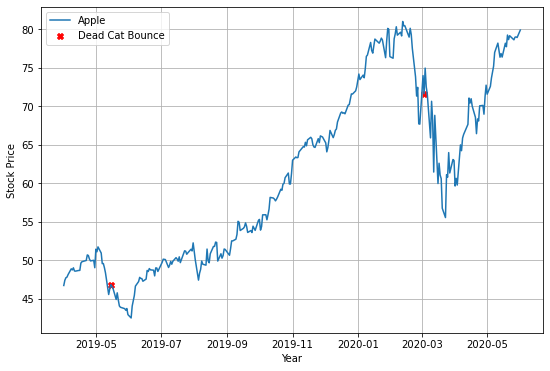

In [20]:
%matplotlib inline

# Plotting only the dead cat bounce appearance from 2019 until June 2020 for better understanding

plot_date_start = '2019-04-1'
plot_date_end = '2020-06-1'
plot_stock = final_df[plot_date_start:plot_date_end].copy()
plot_dcb = dcb_df[plot_date_start:plot_date_end].copy()

plt.figure(figsize=(9,6))
plt.scatter(plot_dcb.index, plot_dcb['Adj Close'], color='r', marker='X', label='Dead Cat Bounce')
plt.plot(plot_stock.index, plot_stock['Adj Close'], label='Apple')

plt.legend(loc="upper left")
plt.xlabel('Year')
plt.ylabel('Stock Price')

plt.grid(True)

plt.show()

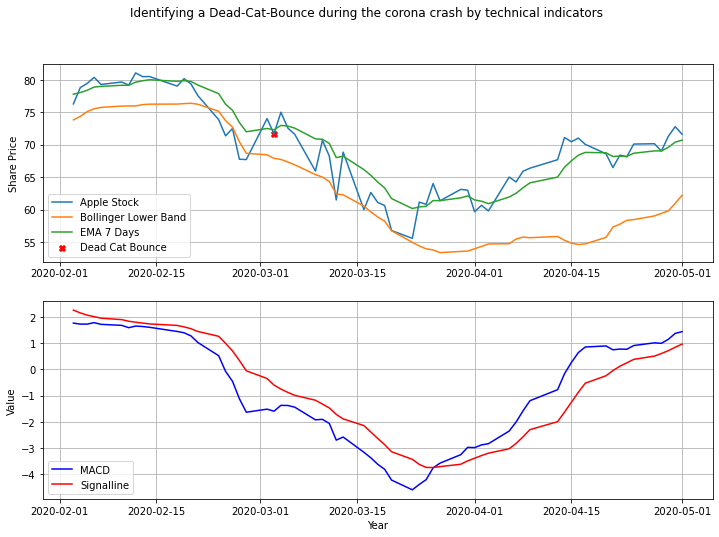

In [21]:
# Plotting a dead cat bounce during the corona crisis crash
# to show, how each indicators correlate with each other

plot_date_start = '2020-02-1'
plot_date_end = '2020-05-1'
plot_stock = final_df[plot_date_start:plot_date_end].copy()
plot_dcb = dcb_df[plot_date_start:plot_date_end].copy()

fig, axs = plt.subplots(2, figsize=(12,8))
fig.suptitle('Identifying a Dead-Cat-Bounce during the corona crash by technical indicators')

axs[0].scatter(plot_dcb.index, plot_dcb['Adj Close'], color='r', marker='X', label='Dead Cat Bounce')
axs[0].plot(plot_stock.index, plot_stock['Adj Close'], label='Apple Stock')
axs[0].plot(plot_stock.index, plot_stock['bollinger_lower_band'], label='Bollinger Lower Band')
axs[0].plot(plot_stock.index, plot_stock['ema'], label='EMA 7 Days')

axs[0].legend(loc="lower left")

axs[1].plot(plot_stock.index, plot_stock['macd'], label='MACD', color='b')
axs[1].plot(plot_stock.index, plot_stock['signalline'], label='Signalline', color='r')

axs[1].legend(loc="lower left")

axs[0].set_ylabel('Share Price')
axs[1].set_xlabel('Year')
axs[1].set_ylabel('Value')

axs[0].grid(True)
axs[1].grid(True)

# plt.grid(True)

plt.show()

In [22]:
features = ['Open', 'Adj Close', 'ema', 'macd', 'signalline', 'bollinger_lower_band']

In [23]:
X = final_df[features].copy()
X.columns

Index(['Open', 'Adj Close', 'ema', 'macd', 'signalline',
       'bollinger_lower_band'],
      dtype='object')

In [24]:
y = final_df[['dead_cat']].copy()
y.columns

Index(['dead_cat'], dtype='object')

In [25]:
y.head()

,dead_cat
date,
2011-08-24,0
2011-08-25,0
2011-08-26,0
2011-08-29,0
2011-08-30,0


In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [27]:
y_train.describe()

,dead_cat
count,1671.000000
mean,0.001197
std,0.034586
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [28]:
# List of values to try for max_depth:
max_depth_range = list(range(1, 10))
# List to store the accuracy for each value of max_depth:
accuracy = []
for depth in max_depth_range:
    
    clf = DecisionTreeClassifier(max_depth = depth, 
                             random_state = 0)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    accuracy.append(score)

In [29]:
cat_classifier = DecisionTreeClassifier(random_state=0, max_leaf_nodes=5)

In [30]:
predictions = cat_classifier.fit(X_train, y_train).predict(X_test)

In [31]:
predictions[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [32]:
y_test['dead_cat'][:10]
y_test[y_test['dead_cat'] == 1]

,dead_cat
date,
2019-05-15,1


In [33]:
accuracy_score(y_true = y_test, y_pred = predictions)

0.9987864077669902

In [34]:
score = cat_classifier.score(X_test, y_test)
print(score)

0.9987864077669902


<p style="font-family: Arial; font-size:1.75em;color:purple; font-style:bold">Note</p>
<br>
I don't think the prediction model is built correctly, as an accuracy of 99% seems to be too high. 
If you know where my mistake is, please contact me at my mail: sarwariadrian@gmail.com  It will be great to have a discussion where I can enhance my code and make this model work more properly.
<br><br>